# LDA implementation

## Loading libraries

In [1]:
# Load libraries
import logging
import pyro
from pyro import poutine

import pandas as pd
import matplotlib.pyplot as plt

from zzz_utils import *
from zzz_utils_plot import *
from lda import *

logging.basicConfig(format="%(relativeCreated) 9d %(message)s", level=logging.INFO)

pyro.clear_param_store()
pyro.set_rng_seed(123)

## LDA model

First we simulate a toy dataset to render the Pyro models.

In [2]:
nTopics = 3    # Topics
nCells = 20    # Cells
nRegions = 10 # Regions
N = [5] * nCells # Cells size

# Simulate data
obj = simulate_lda_dataset(nTopics = nTopics, nCells = nCells, 
                           nRegions = nRegions, N = N, 
                           a = torch.ones(nTopics), b = torch.ones(nRegions))
# transpose so it matches Pyro's input
D = torch.from_numpy(obj['D'].transpose())

Below we define the LDA model with Pyro. Note that data D is a matrix of __nCounts x nCells__, and here we assume that __nCounts__ is the same across cells.

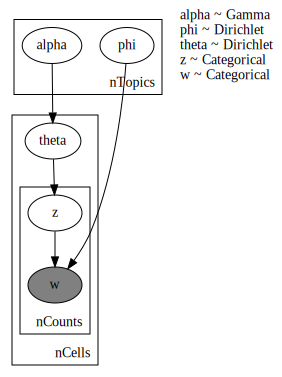

In [3]:
pyro.clear_param_store()
pyro.render_model(lda_model, model_args=(D, nTopics, nRegions), 
                  render_distributions=True, render_params=True)

In [4]:
#trace = pyro.poutine.trace(lda_model).get_trace()
#trace.compute_log_prob()  # optional, but allows printing of log_prob shapes
#print(trace.format_shapes())

## LDA guide (variational approximation)

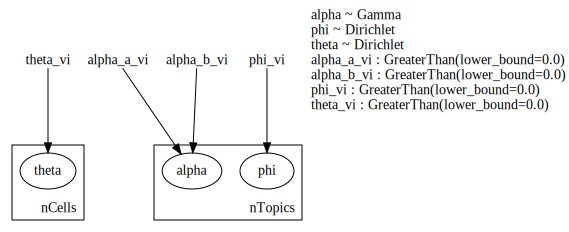

In [5]:
pyro.clear_param_store()
pyro.render_model(lda_guide, model_args=(D, nTopics, nRegions), 
                  render_distributions=True, render_params=True)

# Testing variational inference

## Simulate data
We use simulated data from the LDA model to test the Pyro implementation of LDA inference performance. 
I.e. how close are inferred values to true values used to simulate the data. 

__Note__ there is the known identifiability issue of mixture and mixed-membership models, however we still would expect cell assignments to be consistent with the simulated data.

In [6]:
# Simulate data
pyro.set_rng_seed(123)
nTopics = 2    # Topics
nCells = 400  # Cells
nRegions = 80  # Regions
N = [150] * nCells # Cells size
a = torch.ones(nTopics)/3
b = torch.ones(nRegions)/10

# Simulate data
obj_sim = simulate_lda_dataset(nTopics = nTopics, nCells = nCells, 
                           nRegions = nRegions, N = N, 
                           a = a, b = b)
# Filter to keep only regions with decent coverage
det_thr = 0.05
obj_sim = qc_lda_simulation_object(obj = obj_sim, peak_detection_qc_thr = 0.05)

Number of peak regions passing QC threshold: 47
shape  of D after QC:             (400, 150)
length of D_freq after QC:        400
shape  of theta_true after QC:    torch.Size([400, 2])
shape  of phi_true after QC:      torch.Size([2, 47])
shape  of phi_true_norm after QC: torch.Size([2, 47])


In [7]:
# transpose so it matches Pyro's input
D = torch.from_numpy(obj_sim['D'].transpose())
D.shape # simulated data dims nCounts x nCells

torch.Size([150, 400])

In [8]:
obj_sim['theta_true'][1:10, ] # first 10 cells prob assignments to each topic

tensor([[3.7826e-02, 9.6217e-01],
        [6.6526e-01, 3.3474e-01],
        [2.8452e-01, 7.1548e-01],
        [2.5411e-01, 7.4589e-01],
        [6.7220e-01, 3.2780e-01],
        [7.3451e-01, 2.6549e-01],
        [2.0053e-04, 9.9980e-01],
        [4.0856e-01, 5.9144e-01],
        [3.5590e-03, 9.9644e-01]])

In [9]:
obj_sim['phi_true'][:, 1:10].transpose(0, 1) # first 10 region-topic probs

tensor([[2.0034e-03, 2.5076e-05],
        [1.0399e-05, 1.0622e-03],
        [3.6116e-02, 8.3663e-10],
        [2.6357e-02, 3.1826e-06],
        [4.9693e-06, 1.4029e-03],
        [4.0615e-02, 2.2750e-02],
        [1.5323e-09, 2.1988e-01],
        [1.0853e-03, 9.8729e-13],
        [5.0976e-02, 1.3495e-02]])

In [10]:
vocab = obj_sim['vocab']

## Fit LDA 

To perform inference for Amortized LDA with use ClippedAdam to optimize a 
__trace implementation of ELBO-based SVI__ ('TraceEnum_ELBO'), which supports exhaustive enumeration 
over discrete sample sites, in our case latent topic assignment __z__.

In [11]:
nTopics = 2
nSteps = 1500
lr = 0.1
seed = 123
nRegions = obj_sim['D_freq'].shape[1]

pyro.set_rng_seed(seed)
pyro.clear_param_store()

# We'll fit using SVI.
logging.info("-" * 40)
logging.info("Fitting {} cells".format(D.shape[1]))

elbo = pyro.infer.TraceEnum_ELBO(max_plate_nesting=2)
optim = pyro.optim.ClippedAdam({"lr": lr, 'weight_decay':0.01})
svi = pyro.infer.SVI(lda_model, lda_guide, optim, elbo)
losses = []

logging.info("Step\tLoss")
for step in range(nSteps):
    loss = svi.step(D=D, nTopics=nTopics, nRegions=nRegions)
    if step % 100 == 0:
        logging.info("{: >5d}\t{}".format(step, loss))
    losses.append(loss)
logging.info("final loss = {}".format(loss))

     6820 ----------------------------------------
     6821 Fitting 400 cells
     6822 Step	Loss
     6893     0	268776.5625
    10594   100	163582.390625
    14118   200	160986.96875
    17487   300	160516.71875
    20721   400	158584.203125
    23956   500	160269.03125
    27386   600	158555.5
    30778   700	163456.125
    34472   800	158865.65625
    38014   900	158165.859375
    41650  1000	159757.0625
    45241  1100	158838.8125
    48916  1200	158429.609375
    52559  1300	158715.390625
    56288  1400	158198.734375
    59946 final loss = 159174.28125


Here we plot the elbo loss during optimisation

Text(0, 0.5, 'ELBO loss')

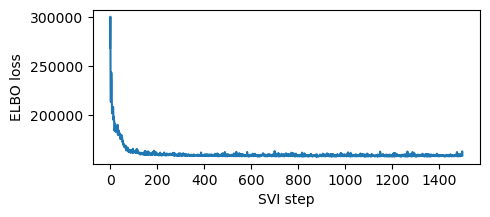

In [12]:
plt.figure(figsize=(5, 2))
plt.plot(losses)
plt.xlabel("SVI step")
plt.ylabel("ELBO loss")

## Assessing inferred parameters

Below we show estimates of the inferred model parameters. To show this, here I am just taking a sample from the 
posterior fit (i.e. calling the guide with the optimized set of variational parameters). Surely this is not the optimal way to summarise the posterior fit. 

__However__, if I take multiple samples from the posterior and subseqently summarise the posterior samples (e.g. by median), due to label switching that occurs when sampling 
$\theta \sim Dir(\alpha)$, the posterior mode will be useless. 

__TODO__ 

1. Define a better way to summarize the posterior distribution from posterior samples. E.g. by fixing the label switching problem, post-hoc after sampling from the posterior (similar approach to mixture models).
2. Make posterior predictive checks.
3. Need to understand Pyro's `poutine`.


In [13]:
pyro.param("alpha_a_vi").detach() / pyro.param("alpha_b_vi").detach()

tensor([0.2902, 0.9792])

In [14]:
pyro.param("phi_vi").detach()

tensor([[7.2773e+00, 1.4373e-01, 1.2700e+01, 2.1086e+01, 1.7293e+01, 3.2368e+01,
         3.8165e+02, 3.6525e+03, 1.0064e-01, 2.5125e+02, 1.9652e+00, 5.9925e+02,
         4.1789e+02, 1.1331e-01, 7.4615e+00, 5.3210e+03, 2.4571e+02, 1.4417e+01,
         2.6329e+01, 1.8784e+01, 4.3613e+02, 1.3209e+02, 1.3151e+02, 3.8009e+02,
         3.7327e+02, 7.7526e+00, 4.1479e+02, 1.0106e+01, 1.3432e+02, 1.2342e+01,
         4.5958e+00, 1.1121e+03, 1.2748e-01, 5.5298e+00, 3.8116e+02, 3.1843e+00,
         1.1515e+03, 4.8317e+00, 1.5929e+02, 2.6261e+01, 8.9033e+02, 3.9401e+00,
         7.3734e+01, 2.8812e+01, 2.4094e+02, 1.3367e+02, 7.7758e+01],
        [4.4391e+02, 3.1706e+01, 1.5964e-01, 6.5668e+02, 3.6850e+02, 1.1328e-01,
         7.6600e+02, 6.1328e+01, 2.2955e+01, 9.0779e+02, 1.2601e+01, 4.6617e+01,
         7.0063e+02, 1.2503e+02, 1.9869e+01, 2.5929e+02, 5.0757e+00, 1.1206e+03,
         2.6051e+02, 5.1913e+00, 2.2908e+02, 5.2023e+01, 2.3932e+00, 1.0130e+03,
         3.2525e+01, 1.9911e+01, 8.4744

In [15]:
#for name, value in pyro.get_param_store().items():
#    print(name, pyro.param(name).data.cpu().numpy())

In [16]:
pyro.param("theta_vi").detach()[1:10, :]

tensor([[ 57.9419,   0.5001],
        [  3.5021,  12.2332],
        [ 45.6278,  10.5492],
        [ 12.6512,   2.5232],
        [  1.7703,   2.5848],
        [ 10.8048,  35.1550],
        [ 89.6761,   0.3357],
        [  2.0646,   1.2234],
        [130.2908,   0.4278]])

In [17]:
# A single sample from the guide
post_sample = lda_guide(D = D, nTopics = nTopics, nRegions = nRegions)

In [18]:
obj_sim['theta_true'][1:10, ] # first 10 cells prob assignments to each topic

tensor([[3.7826e-02, 9.6217e-01],
        [6.6526e-01, 3.3474e-01],
        [2.8452e-01, 7.1548e-01],
        [2.5411e-01, 7.4589e-01],
        [6.7220e-01, 3.2780e-01],
        [7.3451e-01, 2.6549e-01],
        [2.0053e-04, 9.9980e-01],
        [4.0856e-01, 5.9144e-01],
        [3.5590e-03, 9.9644e-01]])

In [19]:
post_sample['theta'][1:10, :] # posterior theta

tensor([[9.9715e-01, 2.8499e-03],
        [2.5573e-01, 7.4427e-01],
        [7.5044e-01, 2.4956e-01],
        [8.7999e-01, 1.2001e-01],
        [6.9707e-01, 3.0293e-01],
        [2.8240e-01, 7.1760e-01],
        [9.9962e-01, 3.8032e-04],
        [5.1975e-01, 4.8025e-01],
        [9.9905e-01, 9.5014e-04]], grad_fn=<SliceBackward0>)

In [20]:
post_sample['phi'][:, 1:10].detach().numpy().transpose() # posterior phi

array([[7.0551420e-10, 2.2486839e-03],
       [8.5507700e-04, 1.5002221e-12],
       [9.8087906e-04, 3.8199477e-02],
       [1.0090123e-03, 2.2856677e-02],
       [1.8004500e-03, 2.3171535e-07],
       [2.1434013e-02, 4.7738392e-02],
       [2.0852847e-01, 3.8947533e-03],
       [5.6217027e-06, 1.3212772e-03],
       [1.6717955e-02, 5.4129504e-02]], dtype=float32)

### Worldclouds

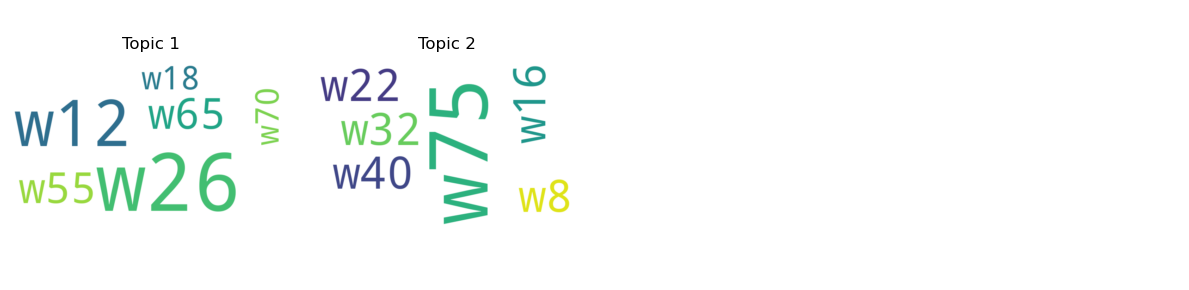

In [21]:
f = make_word_cloud_figure(post_sample['phi'], vocab, 20)

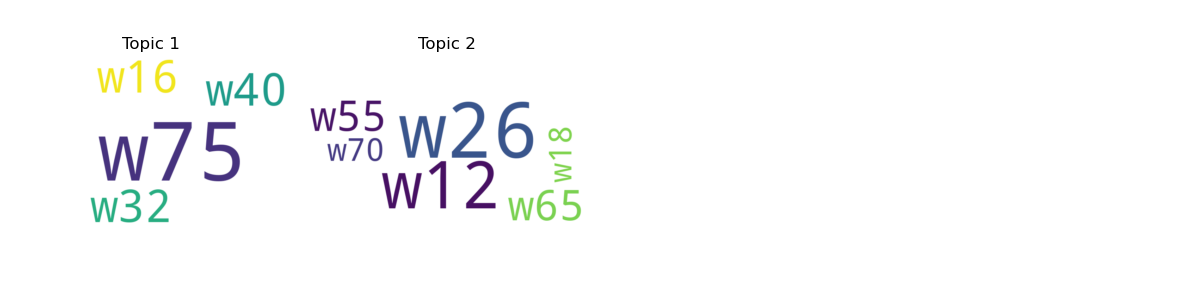

In [22]:
f = make_word_cloud_figure(obj_sim['phi_true'], vocab, 20)

### Topic-cell distribution plots

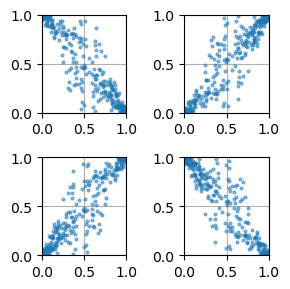

In [24]:
f = make_theta_comparison_plots(theta_true = obj_sim['theta_true'], 
                            theta_infer = post_sample['theta'].detach().numpy())

### Topic-region distribution plots

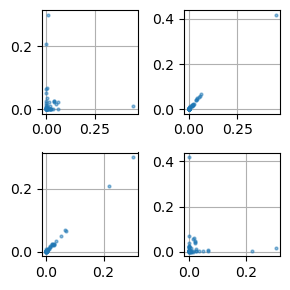

In [32]:
def make_phi_comparison_plots(theta_true,theta_infer):
    """
    Quick plot to compare sets of theta values (presumably true vs inferred)
    Inputs:
    theta_true: array of theta values (true)
    theta_infer: array of theta values (inferred)
    """
    
    ntopics_true  = theta_true.shape[1]
    ntopics_infer = theta_infer.shape[1] 
    fig, axs = plt.subplots(ntopics_true,ntopics_infer,
                            figsize=(ntopics_true*1.5,ntopics_true*1.5))
    
    for i in range(ntopics_true):
        for j in range(ntopics_infer):
            axs[i,j].plot(theta_true[:,i],theta_infer[:,j],'o',markersize=2,alpha=0.5)
            #axs[i,j].set_xlim(0,1)
            #axs[i,j].set_ylim(0,1)
            axs[i,j].grid(True)
            
    
    plt.tight_layout()
    return fig
f = make_phi_comparison_plots(theta_true = obj_sim['phi_true'].transpose(0, 1), 
                            theta_infer = post_sample['phi'].detach().numpy().transpose())